In [1]:
%run '0.0_init_configuration.ipynb'

**Loading the Boston housing data**

In [2]:
# !wet  para obtener los datos
# !wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/data/boston_housing_clean.pickle"

In [3]:
#formato pickle rb=lectura binaria
with open('boston_housing_clean.pickle', 'rb') as to_read:
    boston = pd.read_pickle(to_read)

df = boston['dataframe']
boston_description = boston['description']

In [4]:
boston_description

"Boston House Prices dataset\n===========================\n\nNotes\n------\nData Set Characteristics:  \n\n    :Number of Instances: 506 \n\n    :Number of Attributes: 13 numeric/categorical predictive\n    \n    :Median Value (attribute 14) is usually the target\n\n    :Attribute Information (in order):\n        - CRIM     per capita crime rate by town\n        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.\n        - INDUS    proportion of non-retail business acres per town\n        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)\n        - NOX      nitric oxides concentration (parts per 10 million)\n        - RM       average number of rooms per dwelling\n        - AGE      proportion of owner-occupied units built prior to 1940\n        - DIS      weighted distances to five Boston employment centres\n        - RAD      index of accessibility to radial highways\n        - TAX      full-value property-tax rate per $10,000\n

In [5]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


**Determinar la normalidad**

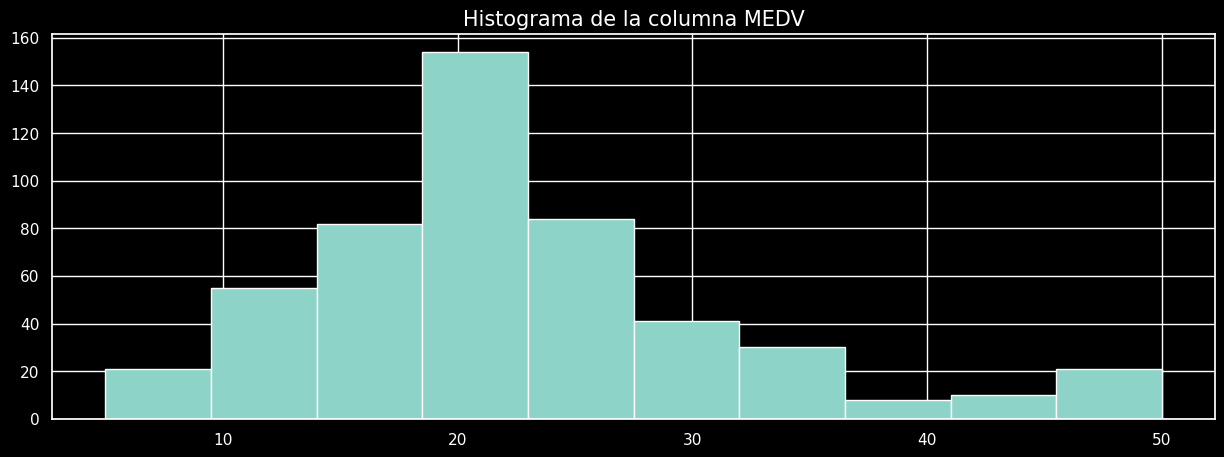

In [6]:
# Determinar la normalidad de la variable objetivo (MEDV)
df.MEDV.hist()
plt.title('Histograma de la columna MEDV', fontsize=15)
plt.show()

A simple vista en la figura se observa que no tiene una distribución normal;ademas,p-value is extremely low. Our y variable which we have been dealing with this whole time was not normally distributed!



In [7]:
# p-value > 0.5 para D.N
normaltest(df.MEDV.values)

NormaltestResult(statistic=np.float64(90.9746873700967), pvalue=np.float64(1.7583188871696095e-20))

**Apply transformation to Boston Housing data:**

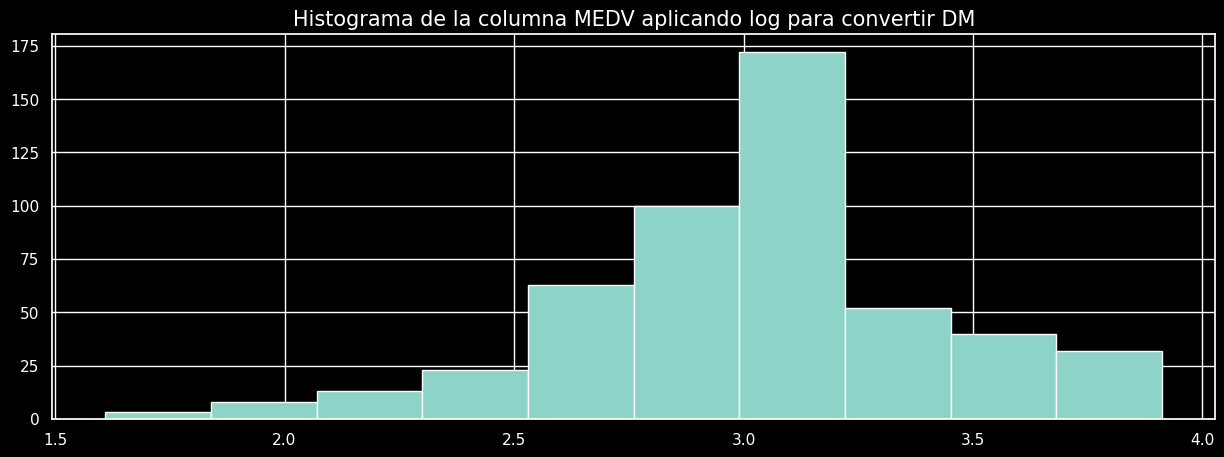

In [8]:
# Método 1: aplicando Long
log_medv = np.log(df.MEDV)

log_medv.hist()
plt.title('Histograma de la columna MEDV aplicando log para convertir DM', fontsize=15)
plt.show()

In [9]:
normaltest(log_medv)

NormaltestResult(statistic=np.float64(17.21801696640698), pvalue=np.float64(0.00018245472768345196))

Conclusion: The output is closer to normal distribution, but still not completely normal.



**Square root transformation**

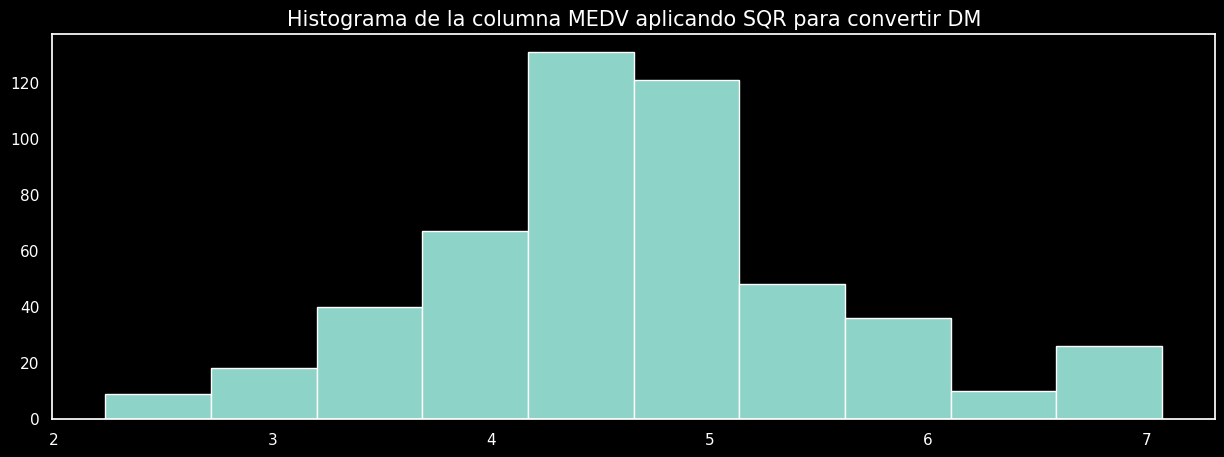

In [10]:
#Método 2 aplicando SQR
sqrt_medv = np.sqrt(df.MEDV)
plt.hist(sqrt_medv)
plt.title('Histograma de la columna MEDV aplicando SQR para convertir DM', fontsize=15)
plt.show()

In [11]:
normaltest(sqrt_medv)

NormaltestResult(statistic=np.float64(20.487090826863067), pvalue=np.float64(3.558645701429252e-05))

**Box Cox Transformation**

In [12]:
# Método 3: Box Cox
bc_result = boxcox(df.MEDV)
boxcox_medv = bc_result[0]
lam = bc_result[1]
print(lam)

0.2166208725297122


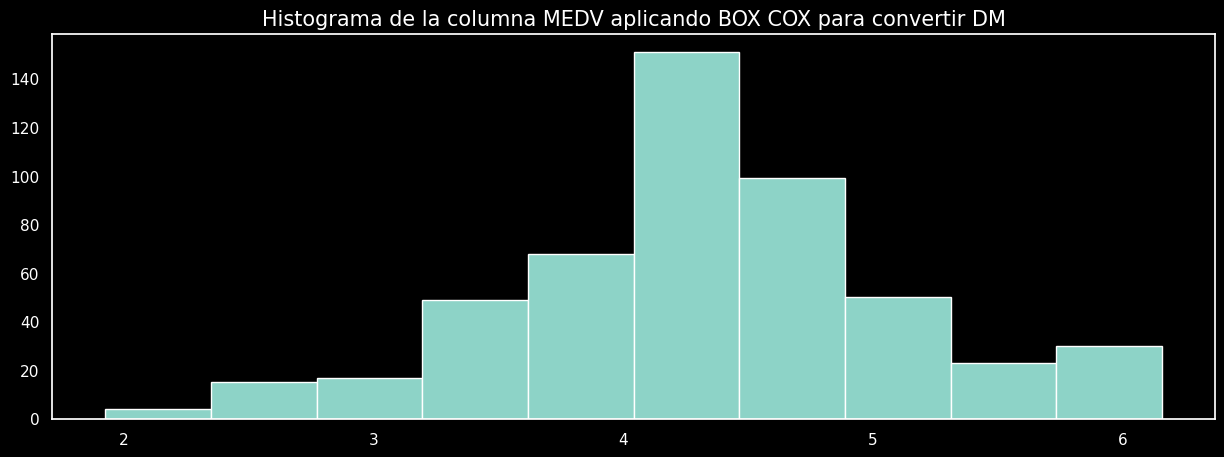

In [13]:
plt.hist(boxcox_medv)
plt.title('Histograma de la columna MEDV aplicando BOX COX para convertir DM', fontsize=15)
plt.show()

In [14]:
normaltest(boxcox_medv)

NormaltestResult(statistic=np.float64(4.5135288641281655), pvalue=np.float64(0.10468866464430764))

We find that the box cox results in a graph which is significantly more normally distributed (according to p value) than the other two distributions.This can be even above 0.05.

**Linear Regression**

In [15]:

lr = LinearRegression()

# Define X and Target variable(y)
y_col = 'MEDV'
X = df.drop(y_col, axis=1)
y = df[y_col]

# Create polynomial features to improve lineal regression
pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.3,random_state=72018)

# Normalize the training data using StandarScaler on X_train, useing fit_transform()
s = StandardScaler()
X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

# Fit regression
lr.fit(X_train_s, y_train)

# Predict

lr_pred = lr.predict(X_test_s)
r_lineal = r2_score(y_test, lr_pred)
r_lineal

0.8689110469231023

**Applying inverse transformation boxcox on target variable (Y)**

In [16]:
# Apply the appropriate transformation
bc_result2 = boxcox(y_train)
y_train_bc = bc_result2[0]
lam2 = bc_result2[1]

y_train_bc.shape

(354,)

In [17]:
# Fit x_train and y_train_bc and the predict_bc
lr.fit(X_train_s, y_train_bc)
y_pred_bc = lr.predict(X_test_s)

#Apply inverse transformation to be able to use these in a regression context
inv_boxcox(boxcox_medv, lam)[:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

In [18]:
df['MEDV'].values[:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

Exactly the same, as we would hope!



In [19]:
#Hint: Use the inv_boxcox() function to get the transformed predicted values
y_pred_tran = inv_boxcox(y_pred_bc, lam2)
r_lineal_boxcox = r2_score(y_test, y_pred_tran)
r_lineal_boxcox

0.888487824633678

In [20]:
results = {'LR' : r_lineal,
           'LR Box-cox' : r_lineal_boxcox}

df_comp = pd.DataFrame(results, index=['R²_score'])
df_comp

,LR,LR Box-cox
R²_score,0.868911,0.888488
